# Create a fractional country mask using exclusively Python libraries

Daan Kivits, 2023

based on the implementations of Ida Storm and Wouter Peters (2022)

In [1]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
from cartopy.mpl.patch import geos_to_path
from shapely.geometry import Point, Polygon
from shapely import affinity
import geopandas
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import os

country_list = read_csv('country_list.csv', header = 0)

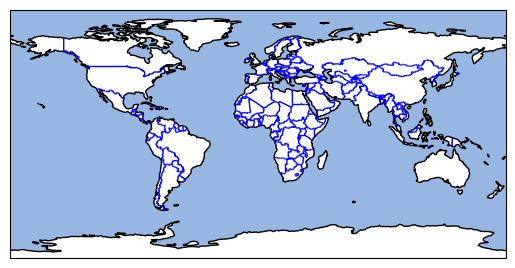

In [2]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)

un_admin = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m')

ax.add_feature(un_admin, facecolor='None', edgecolor='b')

In [3]:
res_lon=0.2  # degrees
res_lat=0.1  # degrees

lon_bounds = [-14.9, 35.1]
lat_bounds = [33.05, 72.05]

nx = int((lon_bounds[1] - lon_bounds[0])/res_lon)
ny = int((lat_bounds[1] - lat_bounds[0])/res_lat)

lons = lon_bounds[0]+np.arange(nx)*res_lon # from 15W to 35E
lats = lat_bounds[0]+np.arange(ny)*res_lat # from 33N to 72N

xv, yv = np.meshgrid(lons, lats)  # Make 2d arrays of the lat/lon points of the 2D grid. Note that each element [i,j] represents the lower-left corner of a gridbox

area=np.cos(np.radians(abs(yv)))*(111.1*111.1*1000*1000)*res_lon*res_lat # Calculate the area of each gridbox in m2

In [4]:
def globarea(im=360, jm=180, silent=True):
    """ Function that calculates the surface area for each grid cell globally according to TM5 definitions"""

    radius = 6.371e6  # the earth radius in meters
    deg2rad = np.pi / 180.
    g = 9.80665 

    dxx = 360.0 / im * deg2rad 
    dyy = 180.0 / jm * deg2rad 
    lat = np.arange(-90 * deg2rad, 90 * deg2rad, dyy)
    dxy = dxx * (np.sin(lat + dyy) - np.sin(lat)) * radius ** 2
    area = np.resize(np.repeat(dxy, im, axis=0) , [jm, im])
    if not silent:
        print('total area of field = ', np.sum(area.flat))
        print('total earth area    = ', 4 * np.pi * radius ** 2)
    return area

In [5]:
def bboxarea(continent = 'Europe', lon_bounds = [-14.9, 35.1], lat_bounds = [33.05, 72.05], res_lon = 0.2, res_lat = 0.1, silent = True):
    """ Function that calculates the surface area for each grid cell over a specific continent according to TM5 definitions"""
    radius = 6.371e6  # the earth radius in meters
    deg2rad = np.pi / 180.
    
    if continent == 'Europe':
        lon_bounds = [-14.9, 35.1]
        lat_bounds = [33.05, 72.05]
    else: 
        NameError
        
    nx = int((lon_bounds[1] - lon_bounds[0])/res_lon)
    ny = int((lat_bounds[1] - lat_bounds[0])/res_lat)
    dxx = (lon_bounds[1] - lon_bounds[0]) / nx * deg2rad 
    dyy = (lat_bounds[1] - lat_bounds[0]) / ny * deg2rad
    
    lat = np.arange(lon_bounds[0] * deg2rad, lon_bounds[1] * deg2rad, dyy)
    dxy = dxx * (np.sin(lat + dyy) - np.sin(lat)) * radius ** 2
    area = np.resize(np.repeat(dxy, nx, axis=0) , [ny, nx])
    if not silent:
        print('total area of field      = ', np.sum(area.flat))
        print('total earth area         = ', 4 * np.pi * radius ** 2)
        print('fields fraction of earth = ', (np.sum(area.flat) / (4 * np.pi * radius ** 2)))
    return area

In [6]:
def get_mask(continent ='Europe', country='Netherlands', natural_earth_res=50, res_lon =1, res_lat=1, lon_bounds = [-14.9, 35.1], lat_bounds = [33.05, 72.05]):
    """ Function that calculates a fractional country mask for a given country (default = Netherlands) based on the Natural Earth library in either '10m', '50m', or '110m' 
    resolution, and also returns an area for each gridcell of the resulting fractional country mask grid. The user can choose a suitable resolution for the latitude/longitude 
    grid for which the fractional grid is calculated. """
          
    shpfilename = shpreader.natural_earth(resolution=str(natural_earth_res) + 'm',
                                      category='cultural',
                                      name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()
    
    if continent == 'Europe':
        lon_bounds = [-14.9, 35.1]
        lat_bounds = [33.05, 72.05]
    else: 
        NameError
        
    nx = int((lon_bounds[1] - lon_bounds[0])/res_lon)
    ny = int((lat_bounds[1] - lat_bounds[0])/res_lat)
    
    shape = [c.geometry for c in countries if c.attributes['SOVEREIGNT'].strip() == country]
    
    frac = np.zeros((ny, nx,))
    area = globarea(nx, ny, silent=True)
    
    mask_list = []
    
    for j in range(ny):
        jj = lat_bounds[0]+res_lat*j  # Latitude; CTE-HR grid: 33N to 72N

        for i in range(nx):
            ii = lon_bounds[0]+res_lon*i  #Longitude; CTE-HR grid: 15W to 35E

            this_point = Point(ii, jj)

            lat_point_list = [jj,jj,jj+1,jj+1,jj]
            lon_point_list = [ii,ii+1,ii+1,ii,ii]

            this_box = Polygon(zip(lon_point_list, lat_point_list))

            for geom in shape:
                if this_box.intersects(geom):
                    frac[j,i] += (this_box.intersection(geom).area/this_box.area)  # fractional mask
    
    frac[frac == 0] = np.nan
    
    return frac, area

In [7]:
def get_mask_continent(countrylist, continent = 'Europe', natural_earth_res=10, res_lon=0.05, res_lat=0.05, test=False, lon_bounds = [-14.9, 35.1], lat_bounds = [33.05, 72.05], fill = 0):
    """ Function that calculates a fractional country mask with the extent of a specific continent (default = Europe) based on the Natural Earth library in either 
    '10m', '50m', or '110m' resolution, and it also returns an area for each gridcell of the resulting fractional country mask grid. The user can choose a 
    suitable resolution for the latitude/longitude grid for which the fractional grid is calculated. These masks are then stored in a list, which is later 
    converted into pandas DataFrame which is then converted into a netCDF file structure. """
    
    shpfilename = shpreader.natural_earth(resolution=str(natural_earth_res) + 'm',
                                      category='cultural',
                                      name='admin_0_countries')
    NEcountries = geopandas.read_file(shpfilename)
    
    mask_list,name_list = ([] for i in range(2))    
    
    if test == True:
        countrylist = countrylist[countrylist['code'] == 'RUS']
        res_lat = res_lon = 1
    
    if continent == 'Europe':
        lon_bounds = [-14.9, 35.1]
        lat_bounds = [33.05, 72.05]
    else: 
        NameError

    nx = int((lon_bounds[1] - lon_bounds[0])/res_lon)
    ny = int((lat_bounds[1] - lat_bounds[0])/res_lat)

    for country in countrylist['code']: 
        if country != 'PRT' and country != 'CYN' and country != 'CYP' and country != 'KOS' and country != 'SRB':
            shape = NEcountries.loc[NEcountries['ADM0_ISO'] == country].geometry.values[0]
            name = NEcountries.loc[NEcountries['ADM0_ISO'] == country].SOVEREIGNT.values[0]
        else:
            shape = NEcountries.loc[NEcountries['SOV_A3'] == country].geometry.values[0]
            name = NEcountries.loc[NEcountries['SOV_A3'] == country].SOVEREIGNT.values[0]
        
        print('Busy with ... ' + str(name), flush=True)
        name_list.append(name)

        frac = np.zeros((ny, nx,))
        
        for j in range(ny):
            jj = lat_bounds[0]+res_lat*j  # Latitude; CTE-HR grid: 33N to 72N

            for i in range(nx):
                ii = lon_bounds[0]+res_lon*i  #Longitude; CTE-HR grid: 15W to 35E

                this_point = Point(ii, jj)

                lat_point_list = [jj,jj,jj+1,jj+1,jj]
                lon_point_list = [ii,ii+1,ii+1,ii,ii]

                this_box = Polygon(zip(lon_point_list, lat_point_list))

                if this_box.intersects(shape):
                    frac[j,i] += (this_box.intersection(shape).area/this_box.area)  # fractional mask
                
        if fill == 'NaN' or fill == np.nan:
            frac[frac == 0] = np.nan
        
        mask_list.append(frac)
        #area_list.append(area)
    
    #return mask_list, area_list, name_list
    return mask_list, name_list

# mask_list, area_list, name_list = get_mask_continent(countrylist = country_list, res_lon = 0.05, res_lat = 0.05, natural_earth_res = 10, test=False)
# mask_list, name_list = get_mask_continent(countrylist = country_list, res_lon = 0.2, res_lat = 0.1, natural_earth_res = 10, test=False)

In [8]:
def get_mask_new(countrylist=country_list, lonv=xv, latv=yv, natural_earth_res = '10', fill = 0, test=False):  # assume lons and lats as 2D-arrays from meshgrid or so, as lower-left corners of gridboxes
    shpfilename = shpreader.natural_earth(resolution=str(natural_earth_res) + 'm',
                                        category='cultural',
                                        name='admin_0_countries')
    NEcountries = geopandas.read_file(shpfilename)

    mask_list,frac_list, name_list = ([] for i in range(3))    

    if test == True:
        countrylist = countrylist[countrylist['code'] == 'NLD']
        res_lat = res_lon = 1

    for country in countrylist['code']: 
        if country != 'PRT' and country != 'CYN' and country != 'CYP' and country != 'KOS' and country != 'SRB':
            shape = NEcountries.loc[NEcountries['ADM0_ISO'] == country].geometry.values[0]
            name = NEcountries.loc[NEcountries['ADM0_ISO'] == country].SOVEREIGNT.values[0]
        elif country == 'GRL':
            shape = NEcountries.loc[NEcountries['ADM0_ISO'] == country].geometry.values[0]
            name = 'Greenland'
        else:
            shape = NEcountries.loc[NEcountries['SOV_A3'] == country].geometry.values[0]
            name = NEcountries.loc[NEcountries['SOV_A3'] == country].SOVEREIGNT.values[0]
        
        print('Busy with ... ' + str(name), flush=True)
        name_list.append(name)

        if lonv.any(): # grid given
            #print('grid given')
            mask=np.zeros(lonv.shape)
            frac=np.zeros(lonv.shape)

        else: # assume global
            #print('assuming global grid')
            mask=np.zeros((180,360,))
            frac=np.zeros((180,360,))

            lons= -180+np.arange(360)        
            lats= -90+np.arange(180)
            
            lonv, latv = np.meshgrid(lons, lats) 
            
        for j in range(latv.shape[0]):
            jj = latv[j,0]
            
            if j+1 < latv.shape[0]:
                dj = latv[j+1,0]-jj   # delta latitude from latitude array, repeat last dj value for final row from previous row
            
            jjp1 = jj+dj  # upper corner of polygon
                
            for i in range(lonv.shape[1]):
                ii = lonv[0,i]
                if i+1 < lonv.shape[1]:  
                    di = lonv[0,i+1]-ii  # delta longitude from longitude array, repeat last di value for final column from last column
                    
                iip1 = ii+di  # right longitude of polygon

                #this_point = Point(ii+0.5*di, jj+0.5*dj)   # center point of Polygon, not needed anymore since we define binary mask based on Polygon now 

                lat_point_list = [jj,jj,jjp1,jjp1,jj]
                lon_point_list = [ii,iip1,iip1,ii,ii]

                this_box = Polygon(zip(lon_point_list, lat_point_list))
                
                if this_box.intersects(shape):
                    frac[j,i] += (this_box.intersection(shape).area/this_box.area)  # fractional mask

                mask[j,i] = max(mask[j,i] , frac[j,i] > 0.0)  # binary mask 1/0 based on ANY overlap with geometry, be careful for double overlap, to maximize at 1.0 still...

                if fill == 'NaN' or fill == np.nan:
                    frac[frac == 0] = np.nan
                    mask[mask == 0] = np.nan
            
        frac_list.append(frac)
        mask_list.append(mask)
                    
    return mask_list, frac_list, name_list 

mask_list, frac_list, name_list = get_mask_new(test=False)

Busy with ... Russia
Busy with ... Norway
Busy with ... Denmark
Busy with ... France
Busy with ... Sweden
Busy with ... Belarus
Busy with ... Ukraine
Busy with ... Poland
Busy with ... Austria
Busy with ... Hungary
Busy with ... Moldova
Busy with ... Romania
Busy with ... Lithuania
Busy with ... Latvia
Busy with ... Estonia
Busy with ... Germany
Busy with ... Bulgaria
Busy with ... Greece
Busy with ... Turkey
Busy with ... Albania
Busy with ... Croatia
Busy with ... Switzerland
Busy with ... Luxembourg
Busy with ... Belgium
Busy with ... Netherlands
Busy with ... Portugal
Busy with ... Spain
Busy with ... Ireland
Busy with ... Italy
Busy with ... Denmark
Busy with ... United Kingdom
Busy with ... Iceland
Busy with ... Slovenia
Busy with ... Finland
Busy with ... Slovakia
Busy with ... Czechia
Busy with ... Northern Cyprus
Busy with ... Cyprus
Busy with ... Bosnia and Herzegovina
Busy with ... North Macedonia
Busy with ... Republic of Serbia
Busy with ... Montenegro
Busy with ... Kosovo

In [9]:
#for i in range(0, 5):
#    plt.imshow(frac_list[i], origin='lower')
#    plt.show()
#    print(name_list[i])

In [10]:
from datetime import datetime

def create_ncfile(countrylist = country_list, lon_bounds = [-14.9, 35.1], lat_bounds = [33.05, 72.05], res_lon = 0.05, res_lat = 0.05, ncfile = 'output.nc', test=False):
    if test == True:
        res_lat = res_lon = 1
        ncfile = 'test.nc'
        countrylist = countrylist[countrylist['code'] == 'RUS']
    
    try:
        os.remove(ncfile)
    except OSError:
        pass

    nx = int((lon_bounds[1] - lon_bounds[0])/res_lon)
    ny = int((lat_bounds[1] - lat_bounds[0])/res_lat)
    lon_list = np.arange(lon_bounds[0],lon_bounds[1], res_lon)
    lat_list = np.arange(lat_bounds[0],lat_bounds[1], res_lat)
    
    mask_nc = nc.Dataset(ncfile, mode='w', format='NETCDF4') 

    # Initialize netCDF dimensions
    mask_nc.createDimension('longitude', nx)
    mask_nc.createDimension('latitude', ny)
    mask_nc.createDimension('countrynumber', 43)

    mask_nc.description = "Fractional country masks for European countries based on the 10m Natural Earth data set. Multiply with flux sets to retain only country-specific flux fields"
    mask_nc.geospatial_lat_resolution = str(res_lat) + " degree"
    mask_nc.geospatial_lon_resolution = str(res_lon) + " degree"
    mask_nc.creation_date = datetime.today().strftime('%Y-%m-%d')
    mask_nc.institution = "Wageningen University, department of Meteorology and Air Quality, Wageningen, the Netherlands"
    mask_nc.contact = "Daan Kivits; daan.kivits@wur.nl"

    # Initialize netCDF variables
    longitude = mask_nc.createVariable('longitude','f4',('longitude'), zlib=True)
    longitude.standard_name = "longitude"
    longitude.axis = "X"
    longitude.units = "degrees_south"
    for lon in range(0, nx):
        longitude[lon] = lon_list[lon]

    latitude = mask_nc.createVariable('latitude','f4',('latitude'), zlib=True)
    latitude.standard_name = "latitude"
    longitude.axis = "Y"
    latitude.units = "degrees_north"
    for lat in range(0, ny):
        latitude[lat] = lat_list[lat]

    areavar = mask_nc.createVariable('area','f4',('latitude', 'longitude'))
    areavar.long_name = "variable area per gridcell"
    areavar.comment = "area is calculated based on the assumption that a degree in latitude or longitude is equal to 111.1km" #"area is calculated based on a spherical earth of 6371 km, assuming a perfect sphere"
    areavar.units = "m^2"
    areavar[:,:] = area

    countryname = mask_nc.createVariable('country_name',str,('countrynumber'))
    countryname.long_name = "full country name"
    countryname.comment = "ISO standard full country name"
    
    countryabbrev = mask_nc.createVariable('country_abbrev',str,('countrynumber'))
    countryabbrev.long_name = "abbreviation of country name"
    countryabbrev.comment = "ISO standard abbreviation of country codes"
    
    countrytimezone = mask_nc.createVariable('country_abbrev_timezone', str, ('countrynumber'))
    countrytimezone.long_name = "abbreviation of country-specific timezone"
    countrytimezone.comment = "ISO standard abbreviation of country-specific timezone"
    
    countryarea = mask_nc.createVariable('country_area','f4',('countrynumber'), zlib=True)
    countryarea.long_name = "total area of each country in the fractional country mask"
    countryarea.comment = "area is calculated based on a spherical earth of 6371 km, assuming a perfect sphere"
    countryarea.units = "m^2"

    #countrymask = mask_nc.createVariable('country_mask','f4',('countrynumber', 'latitude', 'longitude'), zlib=True)
    #countrymask.long_name = "fractional country mask"
    #countrymask.comment = "fractional country mask for each European country"
    #countrymask.units = "m^2"
    
    for country_index in range(0, len(countrylist)):
        if test == True:
            print('WORKING ON ... ' + countrylist['name'][country_index], flush=True)
        else:
            print('WORKING ON ... ' + name_list[country_index], flush=True)

        countrystr = name_list[country_index]
        abbrevstr = countrylist['code'][country_index]
        timezonestr = countrylist['timezone'][country_index]

        countryname._Encoding = 'ascii'
        countryname[country_index] = countrystr
        del countryname._Encoding

        countryabbrev._Encoding = 'ascii'
        countryabbrev[country_index] = abbrevstr
        del countryabbrev._Encoding
        
        countrymask = mask_nc.createVariable(abbrevstr,'f4',('latitude', 'longitude'), zlib=True)
        countrymask.long_name = "fractional country mask for " + countrystr
        
        countrymask[:,:] = frac_list[country_index]
        countryarea[country_index] = np.nansum(areavar * countrymask[:,:])
        countrytimezone[country_index] = timezonestr
    mask_nc.close()

create_ncfile(countrylist = country_list, res_lon = 0.2, res_lat = 0.1, ncfile = 'paris_countrymask_0.2x0.1deg_2D.nc', test=False)

WORKING ON ... Russia
WORKING ON ... Norway
WORKING ON ... Denmark
WORKING ON ... France
WORKING ON ... Sweden
WORKING ON ... Belarus
WORKING ON ... Ukraine
WORKING ON ... Poland
WORKING ON ... Austria
WORKING ON ... Hungary
WORKING ON ... Moldova
WORKING ON ... Romania
WORKING ON ... Lithuania
WORKING ON ... Latvia
WORKING ON ... Estonia
WORKING ON ... Germany
WORKING ON ... Bulgaria
WORKING ON ... Greece
WORKING ON ... Turkey
WORKING ON ... Albania
WORKING ON ... Croatia
WORKING ON ... Switzerland
WORKING ON ... Luxembourg
WORKING ON ... Belgium
WORKING ON ... Netherlands
WORKING ON ... Portugal
WORKING ON ... Spain
WORKING ON ... Ireland
WORKING ON ... Italy
WORKING ON ... Denmark
WORKING ON ... United Kingdom
WORKING ON ... Iceland
WORKING ON ... Slovenia
WORKING ON ... Finland
WORKING ON ... Slovakia
WORKING ON ... Czechia
WORKING ON ... Northern Cyprus
WORKING ON ... Cyprus
WORKING ON ... Bosnia and Herzegovina
WORKING ON ... North Macedonia
WORKING ON ... Republic of Serbia
WORK

In [11]:
#print(np.shape(mask_list), np.shape(area_list), flush=True)

#hpfilename = shpreader.natural_earth(resolution='110m',
#                                      category='cultural',
#                                      name='admin_0_countries')
#reader = shpreader.Reader(shpfilename)
#countries = reader.records()
#countrylist = geopandas.read_file(shpfilename)
#NEcountries = geopandas.read_file(shpfilename)

#for c in countries: 
#    print(c.attributes['ADM0_ISO'])
    
#for c in countries: 
#    print(c.attributes['SOV_A3'])
#print(countrylist.columns.values.tolist())
#print(countrylist.loc[countrylist['ADM0_ISO'] == 'KOS'].SOVEREIGNT.values[0])
#print(NEcountries.loc[NEcountries['SOV_A3'] == 'KOS'].SOVEREIGNT.values)
#print(countrylist.loc[countrylist['ADM0_ISO'] == 'SRB'].SOVEREIGNT.values)
#print(NEcountries.loc[NEcountries['SOV_A3'] == 'SRB'].SOVEREIGNT.values)
#np.array_equal(NEcountries.loc[NEcountries['SOV_A3'] == 'KOS'].geometry.values[0],NEcountries.loc[NEcountries['SOV_A3'] == 'SRB'].geometry.values[0])

## 110 m NaturalEarthFeature resolution
### Make a 0.5 and 0.05 degree country mask
In this example, we create a mask for The Netherlands

In [12]:
frac_mask_110m, area_110m = get_mask(natural_earth_res=110, res_lon=1, res_lat=1) # get the 1 degree fractional country mask
frac_mask_110m_05, area_110m_05 = get_mask(natural_earth_res=110, res_lon=0.5, res_lat=0.5)  # get the 0.5 degree fractional country mask
frac_mask_110m_005, area_110m_005 = get_mask(natural_earth_res=110, res_lon=0.05, res_lat=0.05)  # get the 0.05 degree fractional country mask

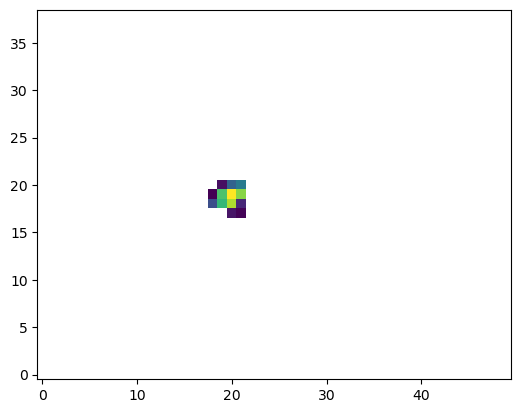

In [13]:
plt.imshow(frac_mask_110m, origin='lower')

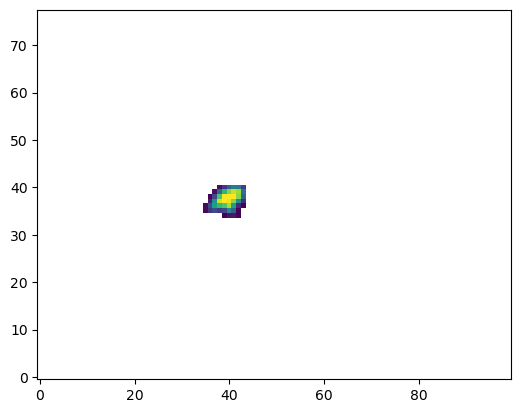

In [14]:
plt.imshow(frac_mask_110m_05, origin='lower')

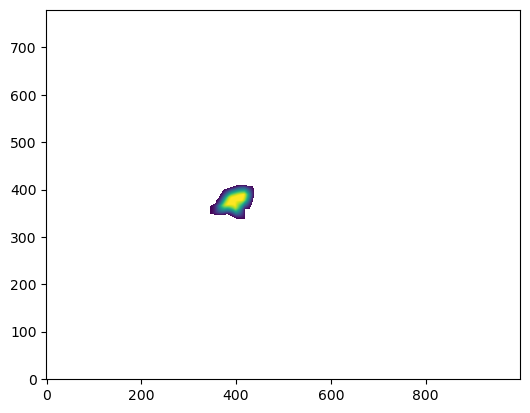

In [15]:
plt.imshow(frac_mask_110m_005, origin='lower')

## 10 m NaturalEarthFeature resolution
### Make a 0.5 and 0.05 degree country mask
In this example, we create a mask for The Netherlands

In [16]:
frac_mask_10m, area_10m = get_mask(natural_earth_res=10, res_lon=1, res_lat=1) # get the 1 degree fractional country mask
frac_mask_10m_05, area_10m_05 = get_mask(natural_earth_res=10, res_lon=0.5, res_lat=0.5)  # get the 0.5 degree fractional country mask
frac_mask_10m_005, area_10m_005 = get_mask(natural_earth_res=10, res_lon=0.05, res_lat=0.05)  # get the 0.05 degree fractional country mask

In [17]:
area_10m_sum = np.nansum(frac_mask_10m*area_10m)/10e6
area_10m_05_sum = np.nansum(frac_mask_10m_05*area_10m_05)/10e6
area_10m_005_sum = np.nansum(frac_mask_10m_005*area_10m_005)/10e6

area_110m_sum = np.nansum(frac_mask_110m*area_110m)/10e6
area_110m_05_sum = np.nansum(frac_mask_110m_05*area_110m_05)/10e6
area_110m_005_sum = np.nansum(frac_mask_110m_005*area_110m_005)/10e6

## Country mask area comparison
Areas are given in km^2 for easier comparison

In [18]:
print('The area of the fractional country mask with a raster resolution of 1x1 degrees using 10m Natural Earth data has an area of ' + str(area_10m_sum) + 'km^2', flush=True)
print('The area of the fractional country mask with a raster resolution of 0.5x0.5 degrees using 10m Natural Earth data has an area of ' + str(area_10m_05_sum) + 'km^2', flush=True)
print('The area of the fractional country mask with a raster resolution of 0.05x0.05 degrees using 10m Natural Earth data has an area of ' + str(area_10m_005_sum) + 'km^2', flush=True)
print('\nThe difference in area between the 1x1 and 0.5x0.5 degrees masks is ' + (str(area_10m_sum - area_10m_05_sum)) + 'km^2 or ' + str(round((area_10m_sum/area_10m_05_sum - 1.0)*100,4)) + '%.', flush=True)
print('The difference in area between the 1x1 and 0.05x0.05 degrees masks is ' + (str(area_10m_sum - area_10m_005_sum)) + 'km^2 or ' + str(round((area_10m_sum/area_10m_005_sum - 1.0)*100,4)) + '%.', flush=True)
print('The difference in area between the 0.5x0.5 and 0.05x0.05 degrees masks is ' + (str(area_10m_05_sum - area_10m_005_sum)) + 'km^2 or ' + str(round((area_10m_05_sum/area_10m_005_sum - 1.0)*100,4)) + '%.', flush=True)

print('\nThe area of the fractional country mask with a raster resolution of 1x1 degrees using 10m Natural Earth data has an area of ' + str(area_110m_sum) + 'km^2', flush=True)
print('The area of the fractional country mask with a raster resolution of 0.5x0.5 degrees using 110m Natural Earth data has an area of ' + str(area_110m_05_sum) + 'km^2', flush=True)
print('The area of the fractional country mask with a raster resolution of 0.05x0.05 degrees using 110m Natural Earth data has an area of ' + str(area_110m_005_sum) + 'km^2', flush=True)
print('\nThe difference in area between the 1x1 and 0.5x0.5 degrees masks is ' + (str(area_110m_sum - area_110m_05_sum)) + 'km^2 or ' + str(round((area_110m_sum/area_110m_05_sum - 1.0)*100,4)) + '%.', flush=True)
print('The difference in area between the 1x1 and 0.05x0.05 degrees masks is ' + (str(area_110m_sum - area_110m_005_sum)) + 'km^2 or ' + str(round((area_110m_sum/area_110m_005_sum - 1.0)*100,4)) + '%.', flush=True)
print('The difference in area between the 0.5x0.5 and 0.05x0.05 degrees masks is ' + (str(area_110m_05_sum - area_110m_005_sum)) + 'km^2 or ' + str(round((area_110m_05_sum/area_110m_005_sum - 1.0)*100,4)) + '%.', flush=True)

The area of the fractional country mask with a raster resolution of 1x1 degrees using 10m Natural Earth data has an area of 200270.48550394646km^2
The area of the fractional country mask with a raster resolution of 0.5x0.5 degrees using 10m Natural Earth data has an area of 200182.2238145307km^2
The area of the fractional country mask with a raster resolution of 0.05x0.05 degrees using 10m Natural Earth data has an area of 200015.4473549535km^2

The difference in area between the 1x1 and 0.5x0.5 degrees masks is 88.26168941575452km^2 or 0.0441%.
The difference in area between the 1x1 and 0.05x0.05 degrees masks is 255.03814899295685km^2 or 0.1275%.
The difference in area between the 0.5x0.5 and 0.05x0.05 degrees masks is 166.77645957720233km^2 or 0.0834%.

The area of the fractional country mask with a raster resolution of 1x1 degrees using 10m Natural Earth data has an area of 215844.55438142447km^2
The area of the fractional country mask with a raster resolution of 0.5x0.5 degrees us

### Comparison of masks using different Natural Earth resolutions

In [19]:
areadif_10m_110m = (area_10m_sum - area_110m_sum)/1e6
areadif_10m_110m_05 = (area_10m_05_sum - area_110m_05_sum)/1e6
areadif_10m_110m_005 = (area_10m_005_sum - area_110m_005_sum)/1e6

print('\nThe difference in area between the 10m 1x1 and 110m 1x1 degrees masks is ' + (str(areadif_10m_110m)) + 'km^2 or ' + str(round((area_10m_sum/area_110m_sum - 1.0)*100,4)) + '%.')
print('The difference in area between the 10m 0.5x0.5 and 110m 0.5x0.5 degrees masks is ' + (str(areadif_10m_110m_05)) + 'km^2 or ' + str(round((area_10m_05_sum/area_110m_05_sum - 1.0)*100,4)) + '%.')
print('The difference in area between the 10m 0.05x0.05 and 110m 0.05x0.05 degrees masks is ' + (str(areadif_10m_110m_005)) + 'km^2 or ' + str(round((area_10m_005_sum/area_110m_005_sum - 1.0)*100,4)) + '%.')


The difference in area between the 10m 1x1 and 110m 1x1 degrees masks is -0.015574068877478014km^2 or -7.2154%.
The difference in area between the 10m 0.5x0.5 and 110m 0.5x0.5 degrees masks is -0.015574268243788015km^2 or -7.2184%.
The difference in area between the 10m 0.05x0.05 and 110m 0.05x0.05 degrees masks is -0.015569208295081073km^2 or -7.2219%.


In [20]:
import csv
area_dict = {'Grid resolution': [1, 0.5, 0.05],
             'Natural Earth 10m': [area_10m_sum, area_10m_05_sum, area_10m_005_sum],
            'Natural Earth 110m': [area_110m_sum, area_110m_05_sum, area_110m_005_sum],
            'Difference (%)': [round((area_10m_sum/area_110m_sum - 1.0)*100,4), round((area_10m_05_sum/area_110m_05_sum - 1.0)*100,4), round((area_10m_005_sum/area_110m_005_sum - 1.0)*100,4)]}
pd.DataFrame(area_dict).reset_index(drop=True).to_csv('area_comparison.csv', index = False)